In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Reshape
from keras.layers import Conv2D, MaxPooling2D, TimeDistributed, LSTM, Conv3D, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import CSVLogger
import psutil

2024-02-26 00:29:59.681884: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.12.0
2.12.0


In [2]:
def print_memory_usage():
    memory = psutil.virtual_memory()
    print(f"Total memory: {memory.total / (1024**3):.2f} GB")
    print(f"Available memory: {memory.available / (1024**3):.2f} GB")
    print(f"Used memory: {memory.used / (1024**3):.2f} GB")
    print(f"Memory usage percentage: {memory.percent}%")

def print_cpu_usage():
    cpu_percent = psutil.cpu_percent(interval=1)
    print(f"CPU Usage: {cpu_percent}%")

In [3]:
import h5py
import gc

def load_combine_shuffle_data_optimized_hdf5():
    with h5py.File('./fl32_data_1.hdf5', 'r') as h5f:
        combined_input = None
        combined_target = None

        for charge_type in ['positive-charge', 'negative-charge']:
            for data_type in ['sig', 'bkg']:
                # Construct dataset names
                input_dataset_name = f'{charge_type}_{data_type}_input'
                target_dataset_name = f'{charge_type}_{data_type}_target'

                # Check if the dataset exists and load data sequentially
                if input_dataset_name in h5f and target_dataset_name in h5f:
                    input_data = h5f[input_dataset_name].astype(np.float32)
                    target_data = h5f[target_dataset_name].astype(np.float32)

                    if combined_input is None:
                        combined_input = input_data
                        combined_target = target_data
                        # Free memory of the loaded data
                        del input_data, target_data
                        gc.collect()

                    else:
                        print_memory_usage()
                        combined_input = np.vstack((combined_input, input_data))
                        combined_target = np.vstack((combined_target, target_data))
                        # Free memory of the loaded data
                        del input_data, target_data
                        gc.collect()

                else:
                    print(f"Dataset {input_dataset_name} or {target_dataset_name} not found.")

        # Shuffling
        indices = np.arange(combined_input.shape[0])
        np.random.shuffle(indices)
        combined_input = combined_input[indices]
        combined_target = combined_target[indices]

        return combined_input, combined_target

# Example usage
X, y = load_combine_shuffle_data_optimized_hdf5()

Total memory: 376.23 GB
Available memory: 321.49 GB
Used memory: 47.89 GB
Memory usage percentage: 14.6%
Total memory: 376.23 GB
Available memory: 318.59 GB
Used memory: 50.79 GB
Memory usage percentage: 15.3%
Total memory: 376.23 GB
Available memory: 317.12 GB
Used memory: 52.26 GB
Memory usage percentage: 15.7%


In [4]:
inf_exists = np.isinf(X).any()
print(inf_exists)

False


In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def display(x_dataset, y_dataset, i):
    # Extract the i-th data point from both datasets
    x_data_point = x_dataset[i]
    y_data_point = y_dataset[i]

    # Check if the index is valid
    if x_data_point.shape != (8, 13, 21):
        raise ValueError("Invalid shape for the x data point")

    # Extracting the transverse momentum (pt) from the y dataset
    pt = y_data_point[8]  # Assuming the 9th variable is at index 8

    fig, ax_main = plt.subplots(figsize=(8, 6))
    divider = make_axes_locatable(ax_main)

    # Add row sum plot as an inset to the main plot
    ax_row = divider.append_axes("right", size="20%", pad=0.4)

    # Add column sum plot below the main plot
    ax_column = divider.append_axes("bottom", size="20%", pad=0.5)

    # Initial plot
    im = ax_main.imshow(x_data_point[0, :, :], cmap='plasma')
    ax_main.invert_yaxis()
    ax_main.set_yticks(np.arange(x_data_point.shape[1]))
    ax_main.set_xticks(np.arange(x_data_point.shape[2]))
    ax_main.set_xlim(0, x_data_point.shape[2]-1)
    ax_main.set_ylim(0, x_data_point.shape[1]-1)
    ax_main.grid(True, color='gray', alpha=0.7)

    # Function to update the animation
    def update(t):
        # Update main plot
        data = x_data_point[t, :, :]
        im.set_data(data)

        # Update row sum plot
        ax_row.clear()
        ax_row.barh(np.arange(data.shape[0]), np.sum(data, axis=1), color='red')
        ax_row.set_ylim(0, data.shape[0]-1)
        ax_row.set_yticks(np.arange(data.shape[0]))
        ax_row.set_xlim(np.min(x_data_point[:, :, :].sum(axis=2)) * 1.1, np.max(x_data_point[:, :, :].sum(axis=2)) * 1.1)
        ax_row.set_xlabel("Row Sum")

        # Update column sum plot
        ax_column.clear()
        ax_column.bar(np.arange(data.shape[1]), np.sum(data, axis=0), color='blue')
        ax_column.set_xlim(0, data.shape[1]-1)
        ax_column.set_xticks(np.arange(data.shape[1]))
        ax_column.set_ylim(np.min(x_data_point[:, :, :].sum(axis=1)) * 1.1, np.max(x_data_point[:, :, :].sum(axis=1)) * 1.1)
        ax_column.set_ylabel("Column Sum")

        # Update labels and grid
        ax_main.set_xlabel("X Position")
        ax_main.set_ylabel("Y Position")


        # Update title for the entire figure
        fig.suptitle(f"Timestep: {t+1} | Data Point: {i} | pt: {pt:.2f}")

    ani = FuncAnimation(fig, update, frames=8, repeat=True)
    plt.close()

    return HTML(ani.to_jshtml())

In [6]:
n = X.shape[0]
X = X.reshape(n,8,13,21)
display(X, y, 19)

In [5]:
X = X.reshape(-1, 8,13,21)
print(X.shape, y.shape)
def to_sum(X, y):
    if X.shape[1:] == (8, 13, 21) and y.shape[1:] == (13, ):
        #y_expanded = np.repeat(y[:,7], 8, axis=0).reshape(-1, 8, 1)
        X_sum = np.sum(X, axis=(1,3))
        n = y.shape[0]
        one_hot = np.zeros((n, 2))

        # Class 1: np.abs(y[:, 8]) >= 2
        one_hot[np.abs(y[:, 8]) >= 2, 0] = 1

        # Class 2: np.abs(y[:, 8]) < 2  == 1
        one_hot[np.abs(y[:, 8]) < 2, 1] = 1
        return np.concatenate((X_sum, y[:,7].reshape(-1, 1)), axis=1), one_hot
    else:
        raise ValueError("Wrong array shape!")
X_sum, y_sum = to_sum(X, y)

del X
del y
gc.collect()
print_memory_usage()
# from imblearn.under_sampling import RandomUnderSampler

# rows_with_inf = np.any(np.isinf(X_sum), axis=1)

# # Invert the boolean array to get rows without infinities
# rows_without_inf = ~rows_with_inf

# # Filter out rows from X_sum and entries from y_sum that contain infinite values
# X_sum_filtered = X_sum[rows_without_inf]
# y_sum_filtered = y_sum[rows_without_inf]


(620506, 8, 13, 21) (620506, 13)
Total memory: 376.23 GB
Available memory: 202.49 GB
Used memory: 163.65 GB
Memory usage percentage: 46.2%


In [6]:
X_sum = X_sum.reshape(-1,14)
print_memory_usage()
X_sum_train, X_sum_test, y_sum_train, y_sum_test = train_test_split(X_sum, y_sum, test_size=0.2, random_state=42)
del X_sum
del y_sum
gc.collect()
print_memory_usage()

Total memory: 376.23 GB
Available memory: 202.40 GB
Used memory: 163.75 GB
Memory usage percentage: 46.2%
Total memory: 376.23 GB
Available memory: 202.38 GB
Used memory: 163.77 GB
Memory usage percentage: 46.2%


In [7]:
print(X_sum_train.shape)
# for row in X_sum_train:
#     print(','.join(map(str, row)))
with open("./test_100000.txt", "w") as f:
    for row in X_sum_train:
        f.write(','.join(map(str, row)) + '\n')

(496404, 14)


In [68]:
from joblib import load
# Replace 'model_path.joblib' with the path to your model file
model_path = './best_unscaled_small_bdt_2class.joblib'
sklearn_model = load(model_path)
sklearn_model

GradientBoostingClassifier(max_depth=10, min_samples_leaf=1500,
                           min_samples_split=3000, n_estimators=1,
                           random_state=42)

In [ ]:
# from xgboost import XGBClassifier

# # Adjusting parameters for XGBClassifier
# params = {
#     'objective': 'multi:softprob',
#     'num_class': 2,
#     'max_depth': 2,
#     'eta': 0.3,
#     'eval_metric': 'mlogloss',
#     'seed': 42,
#     'colsample_bytree': 1,
#     'learning_rate': 0.3,
#     'n_estimators': 100,
#     'subsample': 1
# }

# # Initialize the XGBClassifier with specified parameters
# model = XGBClassifier(**params)

# # Fit the model to your data
# model.fit(X_sum_train, np.argmax(y_sum_train, axis=1))

In [154]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

# Convert parameters to their Scikit-Learn equivalents where possible
sklearn_params = {
    'loss': 'log_loss',  # Use 'deviance' for logistic regression for probabilistic outputs
    'learning_rate': 0.1,  # Equivalent to 'eta'
    'n_estimators': 1,
    'subsample': 1.0,  # For stochastic gradient boosting
    'criterion': 'friedman_mse',
    'min_samples_split': 5000,  # Consider tuning
    'min_samples_leaf': 2500,  # Consider tuning
    'max_depth': 5,
    'max_features': None,  # 'None' means use all features
    'random_state': 42
}

    
# Initialize the GradientBoostingClassifier with specified parameters
sklearn_model = GradientBoostingClassifier(**sklearn_params)

# Assuming X_sum_train and y_sum_train are already defined
# Fit the model to your data
y_train_labels = np.argmax(y_sum_train, axis=1)  # Converting from one-hot to label encoding if necessary
sklearn_model.fit(X_sum_train, y_train_labels)

GradientBoostingClassifier(max_depth=5, min_samples_leaf=2500,
                           min_samples_split=5000, n_estimators=1,
                           random_state=42)

In [147]:
from sklearn.metrics import accuracy_score
import xgboost as xgb
# Assuming X_sum_test is already in the correct shape
# Convert the dataset into DMatrix
dtest = xgb.DMatrix(X_sum_test)

y_pred_proba = sklearn_model.predict_proba(X_sum_test)

# Convert probabilities to predicted class by selecting the class with the highest probability
y_pred = np.argmax(y_pred_proba, axis=1)

# If y_sum_test is one-hot encoded, convert it to label encoded for evaluation
y_test_encoded = np.argmax(y_sum_test, axis=1)

# Calculate the accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy}")

# You can also use other metrics such as log loss, confusion matrix, etc., for a more detailed evaluation.


Accuracy: 0.510676701423023


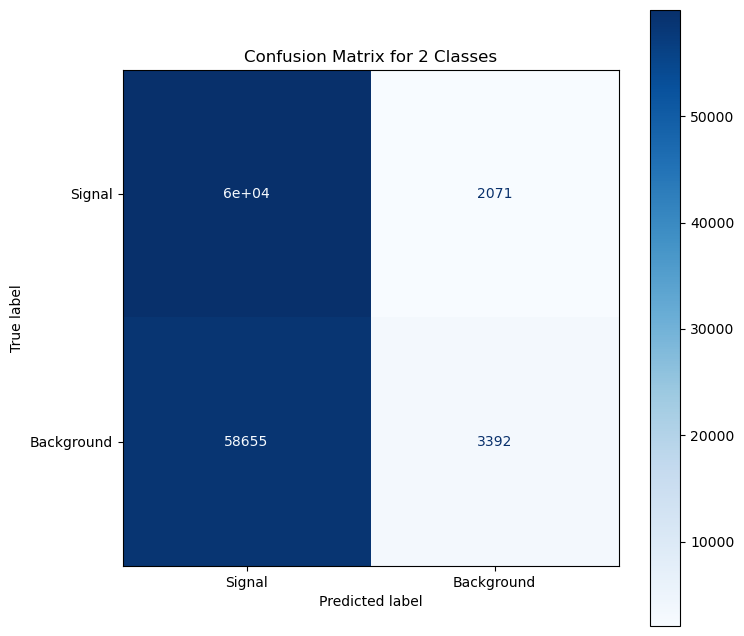

In [155]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict class labels based on the highest probability
y_pred_labels = np.argmax(y_pred_proba, axis=1)

# Compute confusion matrix for the three classes
cm = confusion_matrix(y_test_encoded, y_pred_labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Signal', 'Background'])
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix for 2 Classes')
plt.show()


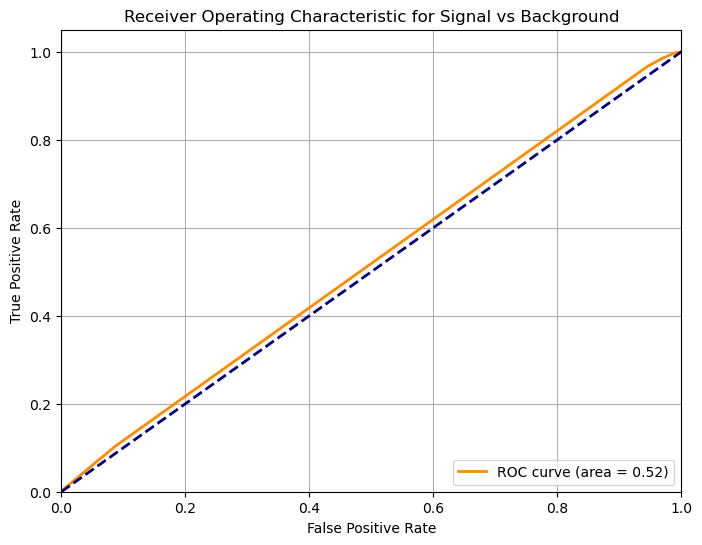

0.5177247984017439

In [156]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assume y_pred_proba[:, 0] contains the probabilities for the signal class

# True binary labels for signal vs background
y_true_binary = (y_test_encoded == 0).astype(int)

# Scores: probability of being the signal
signal_scores = y_pred_proba[:, 0]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true_binary, signal_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Signal vs Background')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Display the AUC
roc_auc


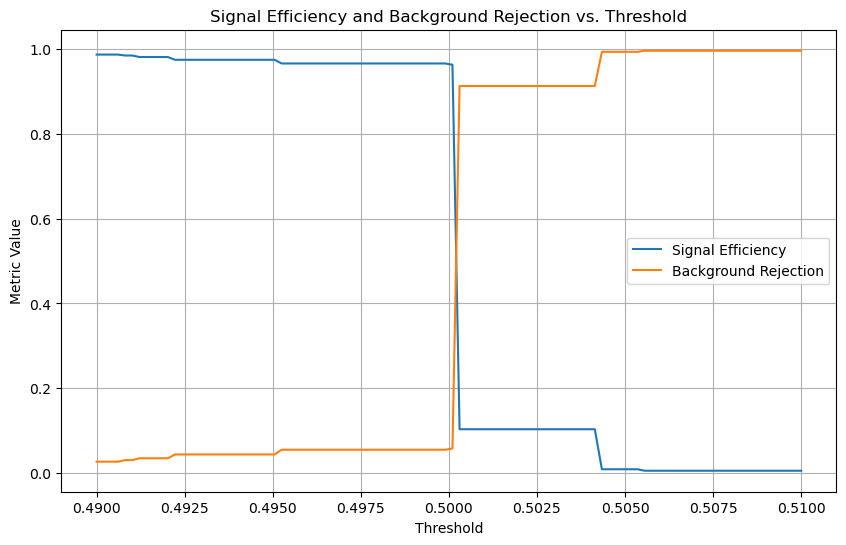

In [157]:
import matplotlib.pyplot as plt

# Assuming y_pred_proba is the probability output from your model for the test set
# and y_test_encoded is the true labels encoded as 0 (signal) and 1,2 (background)

# Calculate signal efficiency and background rejection for a range of thresholds
thresholds = np.linspace(0.49, 0.51, 100)
signal_efficiency = []
background_rejection = []

for thresh in thresholds:
    # Predictions based on threshold
    y_pred_thresh = (y_pred_proba[:, 0] >= thresh).astype(int)
    
    # True Positives for signal
    TP = np.sum((y_pred_thresh == 1) & (y_test_encoded == 0))
    # False Negatives for signal
    FN = np.sum((y_pred_thresh == 0) & (y_test_encoded == 0))
    # False Positives for background
    FP = np.sum((y_pred_thresh == 1) & (y_test_encoded != 0))
    # True Negatives for background
    TN = np.sum((y_pred_thresh == 0) & (y_test_encoded != 0))
    
    # Calculate metrics
    se = TP / (TP + FN) if (TP + FN) > 0 else 0
    br = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    signal_efficiency.append(se)
    background_rejection.append(br)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, signal_efficiency, label='Signal Efficiency')
plt.plot(thresholds, background_rejection, label='Background Rejection')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Signal Efficiency and Background Rejection vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

# signal_efficiency and background_rejection are now stored in arrays


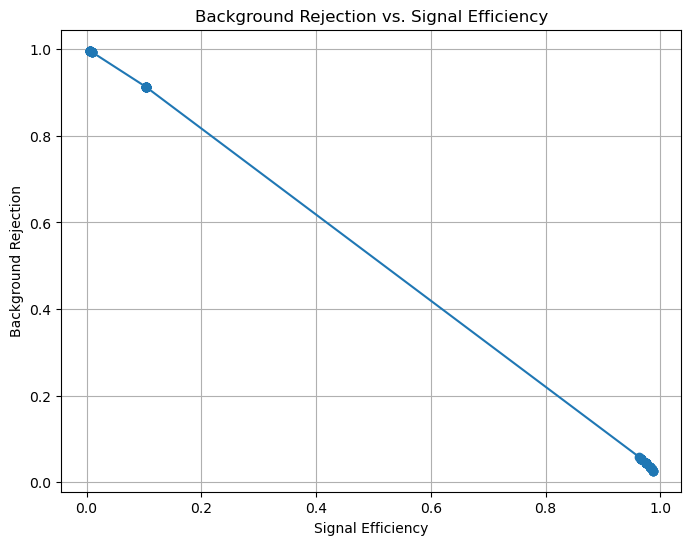

In [158]:
plt.figure(figsize=(8, 6))
plt.plot(signal_efficiency, background_rejection, marker='o', linestyle='-')
plt.xlabel('Signal Efficiency')
plt.ylabel('Background Rejection')
plt.title('Background Rejection vs. Signal Efficiency')
plt.grid(True)
plt.show()

In [159]:
def find_closest(sorted_array, value):
    # Ensure the array is a NumPy array
    sorted_array = np.array(sorted_array)

    # Compute the absolute difference
    abs_diff = np.abs(sorted_array - value)

    # Find the index of the minimum difference
    closest_index = np.argmin(abs_diff)

    return closest_index


index_848 = find_closest(signal_efficiency, 0.848)
index_933 = find_closest(signal_efficiency, 0.933)
index_976 = find_closest(signal_efficiency, 0.976)
print(f"Signal Efficiency:{signal_efficiency[index_848]*100:.2f}%",f"Background Rejections:{background_rejection[index_848]*100:.2f}%",f"with threshold:{thresholds[index_848]:.4f}")
print(f"Signal Efficiency:{signal_efficiency[index_933]*100:.2f}%",f"Background Rejections:{background_rejection[index_933]*100:.2f}%",f"with threshold:{thresholds[index_933]:.4f}")
print(f"Signal Efficiency:{signal_efficiency[index_976]*100:.2f}%",f"Background Rejections:{background_rejection[index_976]*100:.2f}%",f"with threshold:{thresholds[index_976]:.4f}")

Signal Efficiency:96.36% Background Rejections:5.76% with threshold:0.5001
Signal Efficiency:96.36% Background Rejections:5.76% with threshold:0.5001
Signal Efficiency:97.53% Background Rejections:4.35% with threshold:0.4922


In [ ]:
#model.save_model('Best_BDT_small.model')

In [160]:
from joblib import dump
#sklearn_model.save_model('Best_BDT_sklearn.model')
dump(sklearn_model, "best_unscaled_small_bdt_2class.joblib")

['best_unscaled_small_bdt_2class.joblib']